# Retry Algorithm with Stocks and Bits

This notebook implements a retry mechanism for component placement, then fills remaining space with stocks and random bits.

## Strategy

1. **Retry until all components are placed** - Keep trying different random placements until success
2. **Fill 2×2 spaces with stocks** - Add up to 5 stock components in available 2×2 spaces
3. **Fill remaining spaces with "bit" components** - Random 0 or 1 in any remaining single cells

## Components

- **Fixed components**: headlines, github_repo, brandings, quick_links
- **Stocks**: Optional 2×2 components (max 5) with stock data
- **Bits**: Random 0 or 1 in remaining single cells


In [420]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import random
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass
from copy import deepcopy

# Load configuration
with open('../config/component_placement_config.json', 'r') as f:
    config = json.load(f)

print("Grid Configuration:")
print(f"Columns: {config['grid_config']['columns']}")
print(f"Rows: {config['grid_config']['rows']}")
print(f"Cell Size: {config['grid_config']['cell_size']}px")

print("\nComponent Specifications:")
for component in config['components']:
    if 'shapes' in component:
        print(f"- {component['name']}: {component['total_count']} total with flexible shapes {component['shapes']}")
    else:
        print(f"- {component['name']}: {component['width']}x{component['height']} (count: {component['count']})")


Grid Configuration:
Columns: 12
Rows: 16
Cell Size: 48px

Component Specifications:
- headline: 5x4 (count: 4)
- github_repo: 3x3 (count: 1)
- branding: 2x2 (count: 3)
- quick_link: 6 total with flexible shapes [{'width': 6, 'height': 1}, {'width': 4, 'height': 2}]


In [421]:
@dataclass
class Component:
    name: str
    width: int
    height: int
    count: int
    can_rotate: bool
    priority: int
    color: str
    
    def __post_init__(self):
        self.instances = []
        for i in range(self.count):
            self.instances.append({
                'id': f"{self.name}_{i+1}",
                'width': self.width,
                'height': self.height,
                'placed': False,
                'position': None
            })

@dataclass
class FlexibleComponent:
    name: str
    shapes: List[Dict[str, int]]
    total_count: int
    can_rotate: bool
    priority: int
    color: str

@dataclass
class StockComponent:
    symbol: str
    price: float
    change: float
    change_percent: float
    color: str = "#00C851"  # Green for positive, red for negative

@dataclass
class BitComponent:
    value: int  # 0 or 1
    color: str = "#333333"

@dataclass
class DayNumberComponent:
    day_number: int
    color: str = "#4A90E2"  # Blue color

@dataclass
class Placement:
    component_id: str
    x: int
    y: int
    width: int
    height: int
    color: str
    component_type: str
    data: Optional[Dict] = None  # For stocks, bits, etc.

class RetryGridPlacer:
    def __init__(self, grid_width: int, grid_height: int):
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.grid = np.zeros((grid_height, grid_width), dtype=int)
        self.placements = []
        
    def can_place(self, x: int, y: int, width: int, height: int) -> bool:
        """Check if a component can be placed at the given position"""
        if x + width > self.grid_width or y + height > self.grid_height:
            return False
        if x < 0 or y < 0:
            return False
            
        # Check if the area is free
        return np.all(self.grid[y:y+height, x:x+width] == 0)
    
    def place_component(self, component_id: str, x: int, y: int, width: int, height: int, 
                       color: str, component_type: str, data: Optional[Dict] = None) -> bool:
        """Place a component at the given position"""
        if not self.can_place(x, y, width, height):
            return False
            
        # Mark the grid cells as occupied
        self.grid[y:y+height, x:x+width] = 1
        
        # Add to placements
        self.placements.append(Placement(component_id, x, y, width, height, color, component_type, data))
        return True
    
    def get_available_positions(self, width: int, height: int) -> List[Tuple[int, int]]:
        """Get all available positions for a component of given size"""
        positions = []
        for y in range(self.grid_height - height + 1):
            for x in range(self.grid_width - width + 1):
                if self.can_place(x, y, width, height):
                    positions.append((x, y))
        return positions
    
    def get_random_position(self, width: int, height: int) -> Optional[Tuple[int, int]]:
        """Get a random available position"""
        positions = self.get_available_positions(width, height)
        return random.choice(positions) if positions else None
    
    def find_2x2_spaces(self) -> List[Tuple[int, int]]:
        """Find all available 2x2 spaces"""
        return self.get_available_positions(2, 2)
    
    def find_single_cells(self) -> List[Tuple[int, int]]:
        """Find all available single cells"""
        return self.get_available_positions(1, 1)
    
    def find_2x1_spaces(self) -> List[Tuple[int, int]]:
        """Find all available 2x1 spaces"""
        return self.get_available_positions(2, 1)


In [ ]:
def generate_stock_data() -> List[StockComponent]:
    """Generate random stock data"""
    stock_symbols = ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN', 'META', 'NVDA', 'NFLX', 'AMD', 'INTC']
    stocks = []
    
    for i in range(5):  # Max 5 stocks
        symbol = random.choice(stock_symbols)
        price = round(random.uniform(50, 500), 2)
        change = round(random.uniform(-20, 20), 2)
        change_percent = round((change / price) * 100, 2)
        color = "#00C851" if change >= 0 else "#FF4444"
        
        stocks.append(StockComponent(
            symbol=symbol,
            price=price,
            change=change,
            change_percent=change_percent,
            color=color
        ))
    
    return stocks

def reset_all_components(components: List[Component], flexible_components: List[FlexibleComponent]):
    """Reset all component instances to unplaced state"""
    for component in components:
        for instance in component.instances:
            instance['placed'] = False
            instance['position'] = None

def retry_placement_algorithm(components: List[Component], flexible_components: List[FlexibleComponent], 
                             grid_width: int, grid_height: int, max_retries: int = 500) -> RetryGridPlacer:
    """
    Retry algorithm: Keep trying until all components are placed, then add stocks and bits
    """
    print(f"Starting retry algorithm (max {max_retries} attempts)...")
    
    for attempt in range(max_retries):
        print(f"\n--- Attempt {attempt + 1} ---")
        
        # Reset all components for this attempt
        reset_all_components(components, flexible_components)
        
        # Create fresh placer for this attempt
        placer = RetryGridPlacer(grid_width, grid_height)
        
        # Separate brandings from other components
        branding_components = [c for c in components if c.name == 'branding']
        other_components = [c for c in components if c.name != 'branding']
        
        # Step 1: Place brandings randomly
        print("Placing brandings randomly...")
        branding_success = True
        for component in branding_components:
            for instance in component.instances:
                position = placer.get_random_position(instance['width'], instance['height'])
                if position:
                    x, y = position
                    success = placer.place_component(
                        instance['id'], x, y, 
                        instance['width'], instance['height'], 
                        component.color, 'branding'
                    )
                    if success:
                        instance['placed'] = True
                        instance['position'] = (x, y)
                        print(f"  Placed {instance['id']} at ({x}, {y})")
                    else:
                        branding_success = False
                        break
                else:
                    branding_success = False
                    break
            if not branding_success:
                break
        
        if not branding_success:
            print("  Failed to place all brandings, retrying...")
            continue
        
        # Step 2: Place remaining components randomly
        print("Placing remaining components...")
        all_components = []
        
        # Add remaining fixed components
        for component in other_components:
            for instance in component.instances:
                all_components.append({
                    'type': 'fixed',
                    'instance': instance,
                    'component': component
                })
        
        # Add flexible components (randomly choose shapes)
        for flexible_component in flexible_components:
            shapes = flexible_component.shapes
            for i in range(flexible_component.total_count):
                chosen_shape = random.choice(shapes)
                all_components.append({
                    'type': 'flexible',
                    'instance': {
                        'id': f"{flexible_component.name}_{i+1}",
                        'width': chosen_shape['width'],
                        'height': chosen_shape['height'],
                        'placed': False,
                        'position': None
                    },
                    'component': flexible_component
                })
        
        # Randomize order
        random.shuffle(all_components)
        
        # Try to place all components with multiple attempts per component
        all_placed = True
        for item in all_components:
            instance = item['instance']
            component = item['component']
            
            if instance['placed']:
                continue
            
            # Try multiple random positions for this component
            placed_this_component = False
            for _ in range(10):  # Try up to 10 positions
                position = placer.get_random_position(instance['width'], instance['height'])
                if position:
                    x, y = position
                    success = placer.place_component(
                        instance['id'], x, y, 
                        instance['width'], instance['height'], 
                        component.color, instance.get('type', 'fixed')
                    )
                    if success:
                        instance['placed'] = True
                        instance['position'] = (x, y)
                        print(f"  Placed {instance['id']} at ({x}, {y}) - {instance['width']}x{instance['height']}")
                        placed_this_component = True
                        break
            
            if not placed_this_component:
                print(f"  ❌ Could not place {instance['id']} after 10 attempts")
                all_placed = False
                break
        
        if all_placed:
            # Verify all components are actually placed
            total_required = sum(len(c.instances) for c in components) + sum(fc.total_count for fc in flexible_components)
            total_placed = len(placer.placements)
            
            print(f"✅ Success! All components placed in {attempt + 1} attempts")
            print(f"  Required: {total_required}, Placed: {total_placed}")
            break
        else:
            print(f"  Failed to place all components, retrying...")
            continue
    else:
        print(f"❌ Failed to place all components after {max_retries} attempts")
        return placer
    
    # Final verification
    total_required = sum(len(c.instances) for c in components) + sum(fc.total_count for fc in flexible_components)
    total_placed = len(placer.placements)
    
    if total_placed < total_required:
        print(f"⚠️  Warning: Only placed {total_placed}/{total_required} required components")
        print("Proceeding with stocks and bits anyway...")
    else:
        print(f"✅ All {total_required} required components successfully placed!")
    
    # Step 3: Add stocks to available 2x2 spaces
    print("\nAdding stocks to 2x2 spaces...")
    stock_data = generate_stock_data()
    stock_spaces = placer.find_2x2_spaces()
    
    stocks_placed = 0
    for i, (x, y) in enumerate(stock_spaces):
        if stocks_placed >= 5:  # Max 5 stocks
            break
        
        stock = stock_data[stocks_placed]
        success = placer.place_component(
            f"stock_{i+1}", x, y, 2, 2, 
            stock.color, 'stock', 
            {
                'symbol': stock.symbol,
                'price': stock.price,
                'change': stock.change,
                'change_percent': stock.change_percent
            }
        )
        
        if success:
            stocks_placed += 1
            print(f"  Placed stock {stock.symbol} at ({x}, {y}) - ${stock.price} ({stock.change_percent:+.2f}%)")
    
    print(f"Placed {stocks_placed} stocks")
    
    # Step 4: Add 1 day number component to 2x1 space
    print("\nAdding 1 day number component to 2x1 space...")
    day_spaces = placer.find_2x1_spaces()
    day_numbers_placed = 0
    
    if day_spaces:
        # Pick a random day number (1-31)
        day_number = random.randint(1, 31)
        
        # Use the first available 2x1 space
        x, y = day_spaces[0]
        success = placer.place_component(
            "day_1", x, y, 2, 1, 
            "#4A90E2", 'dayNumber', 
            {'day_number': day_number}
        )
        
        if success:
            day_numbers_placed = 1
            print(f"  Placed day number {day_number} at ({x}, {y})")
        else:
            print("  Failed to place day number")
    else:
        print("  No 2x1 spaces available for day number")
    
    # Step 5: Fill remaining single cells with bits
    print("\nFilling remaining cells with bits...")
    single_cells = placer.find_single_cells()
    bits_placed = 0
    
    for i, (x, y) in enumerate(single_cells):
        bit_value = random.randint(0, 1)
        color = "#00C851" if bit_value == 1 else "#FF4444"
        
        success = placer.place_component(
            f"bit_{i+1}", x, y, 1, 1, 
            color, 'bit', 
            {'value': bit_value}
        )
        
        if success:
            bits_placed += 1
    
    print(f"Placed {bits_placed} bits")
    
    # Final summary
    print(f"\n📊 Final Summary:")
    print(f"  Required components: {total_required}")
    print(f"  Placed components: {len(placer.placements)}")
    print(f"  Stocks: {stocks_placed}")
    print(f"  Day numbers: {day_numbers_placed}")
    print(f"  Bits: {bits_placed}")
    print(f"  Total efficiency: {len(placer.placements) / (grid_width * grid_height) * 100:.1f}%")
    
    return placer


In [423]:
def visualize_placement(placer: RetryGridPlacer, title: str = "Retry Algorithm with Stocks and Bits"):
    """Visualize the component placement with colorful boxes"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 16))
    
    # Draw grid
    for i in range(placer.grid_height + 1):
        ax.axhline(y=i, color='black', linewidth=0.5, alpha=0.3)
    for i in range(placer.grid_width + 1):
        ax.axvline(x=i, color='black', linewidth=0.5, alpha=0.3)
    
    # Draw placed components
    for placement in placer.placements:
        rect = patches.Rectangle(
            (placement.x, placement.y), 
            placement.width, 
            placement.height,
            linewidth=2, 
            edgecolor='black', 
            facecolor=placement.color,
            alpha=0.7
        )
        ax.add_patch(rect)
        
        # Add component ID text
        center_x = placement.x + placement.width / 2
        center_y = placement.y + placement.height / 2
        
        if placement.component_type == 'stock' and placement.data:
            text = f"{placement.data['symbol']}\n${placement.data['price']}"
        elif placement.component_type == 'dayNumber' and placement.data:
            text = f"Day {placement.data['day_number']}"
        elif placement.component_type == 'bit' and placement.data:
            text = str(placement.data['value'])
        else:
            text = placement.component_id
            
        ax.text(center_x, center_y, text, 
                ha='center', va='center', fontsize=8, fontweight='bold')
    
    ax.set_xlim(-0.5, placer.grid_width + 0.5)
    ax.set_ylim(-0.5, placer.grid_height + 0.5)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.invert_yaxis()  # Invert y-axis so (0,0) is top-left
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    total_cells = placer.grid_width * placer.grid_height
    occupied_cells = np.sum(placer.grid)
    wasted_cells = total_cells - occupied_cells
    efficiency = (occupied_cells / total_cells) * 100
    
    print(f"\nPlacement Statistics:")
    print(f"Total grid cells: {total_cells}")
    print(f"Occupied cells: {occupied_cells}")
    print(f"Wasted cells: {wasted_cells}")
    print(f"Efficiency: {efficiency:.1f}%")
    print(f"Components placed: {len(placer.placements)}")
    
    # Count by component type
    component_counts = {}
    for placement in placer.placements:
        comp_type = placement.component_type
        component_counts[comp_type] = component_counts.get(comp_type, 0) + 1
    
    print(f"\nComponent breakdown:")
    for comp_type, count in component_counts.items():
        print(f"  {comp_type}: {count}")
    
    # Show stock data
    stocks = [p for p in placer.placements if p.component_type == 'stock']
    if stocks:
        print(f"\nStock data:")
        for stock in stocks:
            data = stock.data
            print(f"  {data['symbol']}: ${data['price']} ({data['change_percent']:+.2f}%)")
    
    # Show bit statistics
    bits = [p for p in placer.placements if p.component_type == 'bit']
    if bits:
        ones = sum(1 for b in bits if b.data and b.data['value'] == 1)
        zeros = len(bits) - ones
        print(f"\nBit statistics:")
        print(f"  1s: {ones}, 0s: {zeros}")


In [424]:
# Create component objects from config
components = []
flexible_components = []

for comp_config in config['components']:
    if 'shapes' in comp_config:
        # This is a flexible component
        flexible_component = FlexibleComponent(
            name=comp_config['name'],
            shapes=comp_config['shapes'],
            total_count=comp_config['total_count'],
            can_rotate=comp_config['can_rotate'],
            priority=comp_config['priority'],
            color=comp_config['color']
        )
        flexible_components.append(flexible_component)
    else:
        # This is a fixed-size component
        component = Component(
            name=comp_config['name'],
            width=comp_config['width'],
            height=comp_config['height'],
            count=comp_config['count'],
            can_rotate=comp_config['can_rotate'],
            priority=comp_config['priority'],
            color=comp_config['color']
        )
        components.append(component)

# Get grid dimensions
grid_width = config['grid_config']['columns']
grid_height = config['grid_config']['rows']

print(f"Grid size: {grid_width}x{grid_height}")
print(f"Total available cells: {grid_width * grid_height}")

# Calculate total space needed
total_space_needed = 0
for component in components:
    space_per_component = component.width * component.height
    total_space = space_per_component * component.count
    total_space_needed += total_space
    print(f"{component.name}: {space_per_component} cells each × {component.count} = {total_space} cells")

# For flexible components, calculate average space needed
for flexible_component in flexible_components:
    avg_space = sum(shape['width'] * shape['height'] for shape in flexible_component.shapes) / len(flexible_component.shapes)
    total_avg_space = avg_space * flexible_component.total_count
    total_space_needed += total_avg_space
    print(f"{flexible_component.name}: ~{avg_space:.1f} cells each × {flexible_component.total_count} = {total_avg_space:.1f} cells (flexible)")

print(f"\nTotal space needed (estimated): {total_space_needed:.1f} cells")
print(f"Space available: {grid_width * grid_height} cells")
print(f"Can fit: {'Yes' if total_space_needed <= grid_width * grid_height else 'No'}")


Grid size: 12x16
Total available cells: 192
headline: 20 cells each × 4 = 80 cells
github_repo: 9 cells each × 1 = 9 cells
branding: 4 cells each × 3 = 12 cells
quick_link: ~7.0 cells each × 6 = 42.0 cells (flexible)

Total space needed (estimated): 143.0 cells
Space available: 192 cells
Can fit: Yes


Running Retry Algorithm with Stocks and Bits...
Starting retry algorithm (max 500 attempts)...

--- Attempt 1 ---
Placing brandings randomly...
  Placed branding_1 at (0, 6)
  Placed branding_2 at (3, 13)
  Placed branding_3 at (7, 4)
Placing remaining components...
  Placed github_repo_1 at (7, 8) - 3x3
  Placed headline_3 at (0, 1) - 5x4
  Placed quick_link_1 at (7, 12) - 4x2
  Placed quick_link_2 at (1, 15) - 6x1
  Placed headline_1 at (7, 0) - 5x4
  Placed quick_link_3 at (8, 6) - 4x2
  Placed quick_link_5 at (1, 0) - 6x1
  Placed quick_link_4 at (5, 11) - 6x1
  Placed headline_4 at (0, 8) - 5x4
  ❌ Could not place headline_2 after 10 attempts
  Failed to place all components, retrying...

--- Attempt 2 ---
Placing brandings randomly...
  Placed branding_1 at (10, 10)
  Placed branding_2 at (1, 5)
  Placed branding_3 at (4, 0)
Placing remaining components...
  Placed quick_link_5 at (0, 7) - 6x1
  Placed headline_4 at (5, 9) - 5x4
  Placed quick_link_6 at (3, 8) - 6x1
  Placed quic

  ❌ Could not place headline_4 after 10 attempts
  Failed to place all components, retrying...

--- Attempt 17 ---
Placing brandings randomly...
  Placed branding_1 at (5, 9)
  Placed branding_2 at (2, 11)
  Placed branding_3 at (6, 12)
Placing remaining components...
  Placed quick_link_1 at (4, 6) - 6x1
  Placed headline_2 at (1, 0) - 5x4
  Placed quick_link_2 at (2, 13) - 4x2
  Placed headline_1 at (7, 1) - 5x4
  Placed headline_3 at (7, 7) - 5x4
  Placed quick_link_5 at (8, 12) - 4x2
  Placed quick_link_3 at (1, 4) - 6x1
  Placed github_repo_1 at (1, 6) - 3x3
  Placed quick_link_4 at (5, 11) - 6x1
  ❌ Could not place headline_4 after 10 attempts
  Failed to place all components, retrying...

--- Attempt 18 ---
Placing brandings randomly...
  Placed branding_1 at (2, 10)
  Placed branding_2 at (5, 11)
  Placed branding_3 at (3, 4)
Placing remaining components...
  Placed headline_2 at (5, 4) - 5x4
  Placed quick_link_1 at (6, 2) - 4x2
  Placed headline_3 at (0, 6) - 5x4
  Placed qui

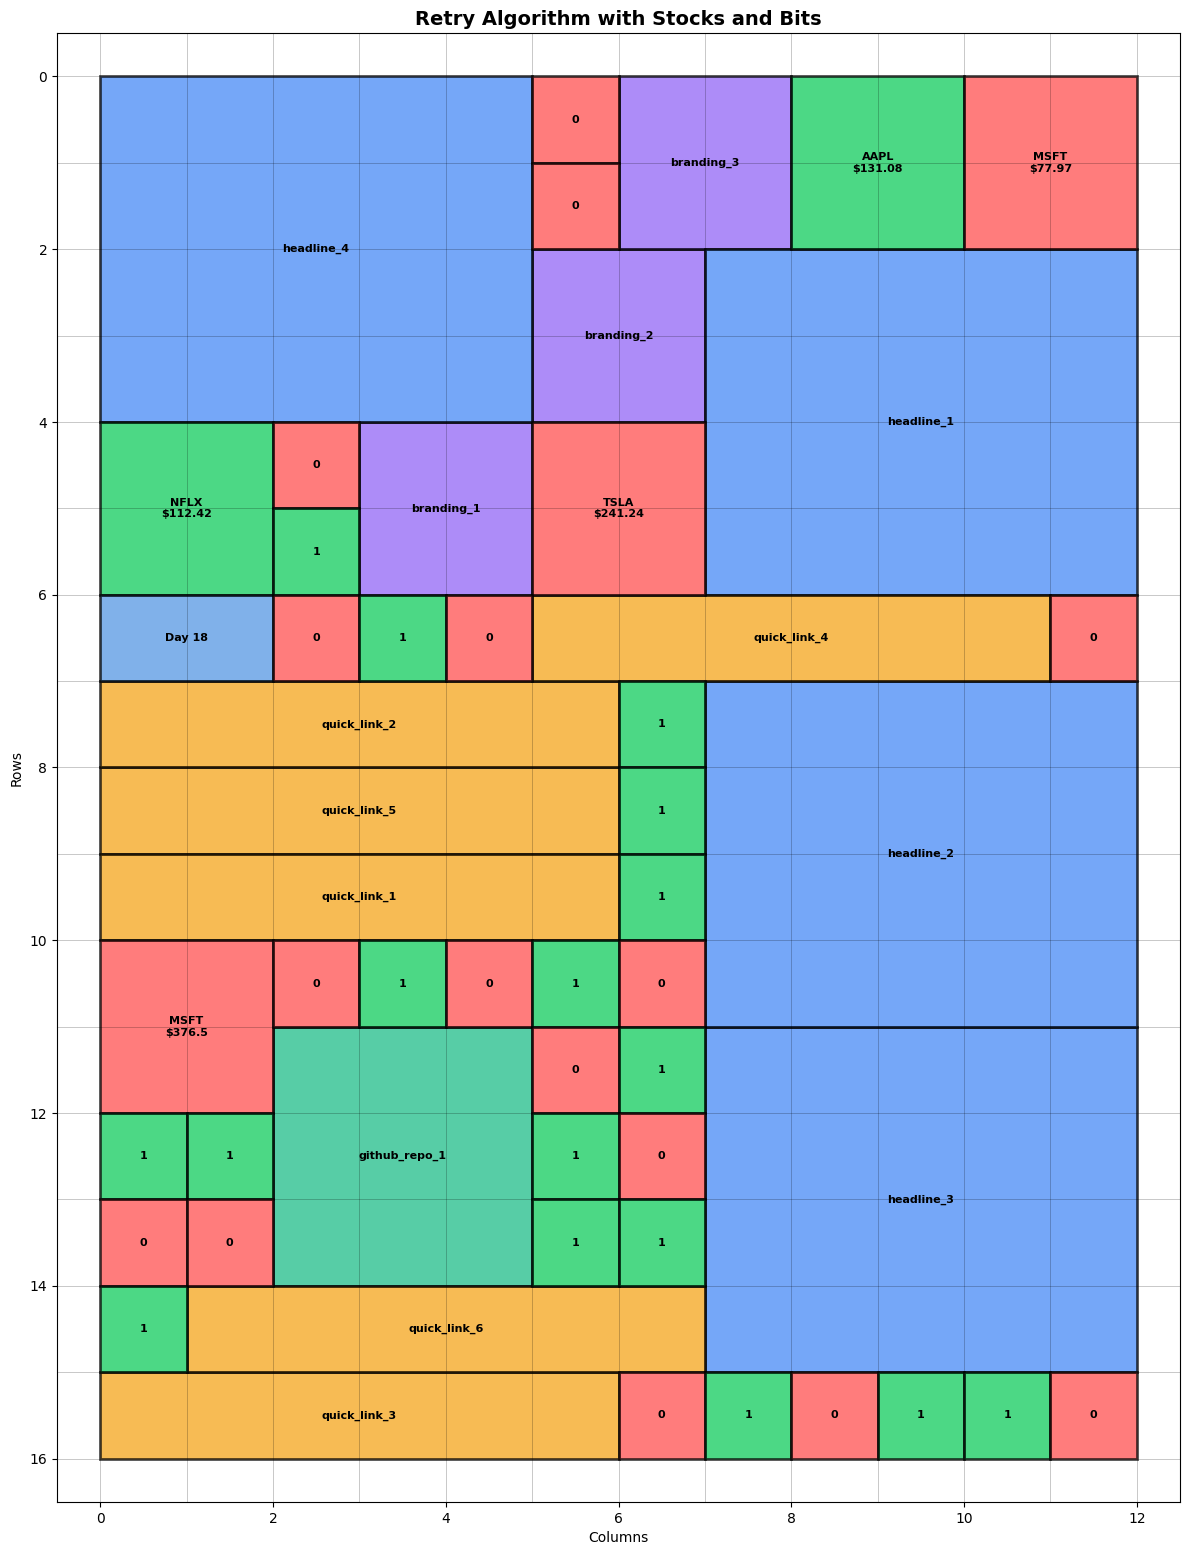


Placement Statistics:
Total grid cells: 192
Occupied cells: 192
Wasted cells: 0
Efficiency: 100.0%
Components placed: 53

Component breakdown:
  branding: 3
  fixed: 11
  stock: 5
  dayNumber: 1
  bit: 33

Stock data:
  AAPL: $131.08 (+11.44%)
  MSFT: $77.97 (-23.03%)
  NFLX: $112.42 (+14.76%)
  TSLA: $241.24 (-2.06%)
  MSFT: $376.5 (-0.14%)

Bit statistics:
  1s: 17, 0s: 16


In [425]:
# Run the retry algorithm with stocks and bits
print("Running Retry Algorithm with Stocks and Bits...")
print("=" * 60)

placer = retry_placement_algorithm(components, flexible_components, grid_width, grid_height)

# Visualize the result
visualize_placement(placer, "Retry Algorithm with Stocks and Bits")


In [426]:
def export_to_frontend_format(placer: RetryGridPlacer) -> dict:
    """Export the placement solution in frontend-compatible format"""
    
    # Convert placements to frontend format
    frontend_components = []
    
    for placement in placer.placements:
        # Determine component type
        if 'headline' in placement.component_id:
            comp_type = 'headline'
        elif 'github_repo' in placement.component_id:
            comp_type = 'gitRepo'
        elif 'branding' in placement.component_id:
            comp_type = 'branding'
        elif 'quick_link' in placement.component_id:
            comp_type = 'quickLink'
        elif placement.component_type == 'stock':
            comp_type = 'stock'
        elif placement.component_type == 'dayNumber':
            comp_type = 'dayNumber'
        elif placement.component_type == 'bit':
            comp_type = 'bit'
        else:
            comp_type = 'unknown'
        
        frontend_component = {
            'id': placement.component_id,
            'type': comp_type,
            'position': {
                'row': placement.y + 1,  # Frontend uses 1-based indexing
                'column': placement.x + 1,
                'width': placement.width,
                'height': placement.height
            },
            'clickable': True,
            'url': f'https://example.com/{placement.component_id}'
        }
        
        # Add type-specific properties
        if comp_type == 'headline':
            frontend_component.update({
                'title': f'Headline {placement.component_id.split("_")[1]}',
                'description': f'Description for {placement.component_id}',
                'source': 'Tech News',
                'publishedAt': '2025-09-27T10:00:00Z',
                'priority': 1
            })
        elif comp_type == 'gitRepo':
            frontend_component.update({
                'name': f'repo-{placement.component_id.split("_")[1]}',
                'stars': random.randint(1000, 100000),
                'description': f'GitHub repository description for {placement.component_id}'
            })
        elif comp_type == 'branding':
            frontend_component.update({
                'text': 'BIT' if 'bit' in placement.component_id else 'BY',
                'variant': 'bit' if 'bit' in placement.component_id else 'by'
            })
        elif comp_type == 'quickLink':
            frontend_component.update({
                'title': f'Quick Link {placement.component_id.split("_")[1]}'
            })
        elif comp_type == 'stock' and placement.data:
            frontend_component.update({
                'symbol': placement.data['symbol'],
                'price': placement.data['price'],
                'change': placement.data['change'],
                'change_percent': placement.data['change_percent']
            })
        elif comp_type == 'dayNumber' and placement.data:
            frontend_component.update({
                'day_number': placement.data['day_number']
            })
        elif comp_type == 'bit' and placement.data:
            frontend_component.update({
                'value': placement.data['value']
            })
        
        frontend_components.append(frontend_component)
    
    # Create the complete layout
    layout = {
        'gridConfig': {
            'columns': placer.grid_width,
            'rows': placer.grid_height,
            'cellSize': 48
        },
        'components': frontend_components
    }
    
    return layout

# Export the current placement to frontend format
frontend_layout = export_to_frontend_format(placer)

# Save to file
import json
with open('../data/retry_stocks_bits_layout.json', 'w') as f:
    json.dump(frontend_layout, f, indent=2)

print("Frontend layout exported to: ../data/retry_stocks_bits_layout.json")
print(f"Total components: {len(frontend_layout['components'])}")

# Display the exported layout
print("\nExported Layout Preview:")
print("=" * 40)
for comp in frontend_layout['components']:
    pos = comp['position']
    print(f"{comp['id']}: {comp['type']} at ({pos['column']}, {pos['row']}) - {pos['width']}x{pos['height']}")


Frontend layout exported to: ../data/retry_stocks_bits_layout.json
Total components: 53

Exported Layout Preview:
branding_1: branding at (4, 5) - 2x2
branding_2: branding at (6, 3) - 2x2
branding_3: branding at (7, 1) - 2x2
headline_3: headline at (8, 12) - 5x4
headline_2: headline at (8, 8) - 5x4
headline_4: headline at (1, 1) - 5x4
quick_link_3: quickLink at (1, 16) - 6x1
quick_link_5: quickLink at (1, 9) - 6x1
github_repo_1: gitRepo at (3, 12) - 3x3
quick_link_6: quickLink at (2, 15) - 6x1
headline_1: headline at (8, 3) - 5x4
quick_link_2: quickLink at (1, 8) - 6x1
quick_link_4: quickLink at (6, 7) - 6x1
quick_link_1: quickLink at (1, 10) - 6x1
stock_1: stock at (9, 1) - 2x2
stock_3: stock at (11, 1) - 2x2
stock_4: stock at (1, 5) - 2x2
stock_6: stock at (6, 5) - 2x2
stock_9: stock at (1, 11) - 2x2
day_1: dayNumber at (1, 7) - 2x1
bit_1: bit at (6, 1) - 1x1
bit_2: bit at (6, 2) - 1x1
bit_3: bit at (3, 5) - 1x1
bit_4: bit at (3, 6) - 1x1
bit_5: bit at (3, 7) - 1x1
bit_6: bit at (4, 